## Pre-requisites

Before running this notebook, you should have already used the `extract_features.py` script to extract features from models trained on DHS data. You should have the following structure under the `outputs/` directory:

```
dhs_ooc/
    DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001/
        features.npz
    ...
    DHS_OOC_E_rgb_same_b64_fc001_conv001_lr0001/
        features.npz
dhs_incountry/
    DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001/
        features.npz
    ...
    DHS_Incountry_E_nl_random_b64_fc01_conv01_lr001/
        features.npz
transfer/
    transfer_nlcenter_ms_b64_fc001_conv001_lr0001/
        features.npz
    transfer_nlcenter_rgb_b64_fc001_conv001_lr0001/
        features.npz
        

TODO: update when keep-frac models are added
```

## Instructions

This notebook essentially performs fine-tuning of the final-layer of the Resnet-18 models. However, instead of directly fine-tuning the Resnet-18 models in TensorFlow, we train ridge-regression models using the extracted features. We take this approach for two reasons:

1. It is easier to perform leave-one-group-out ("logo") cross-validated ridge regression using scikit-learn, as opposed to TensorFlow. For out-of-country (OOC) experiments, the left-out group is the test country. For in-country experiments, the left-out group is the test split.
2. We can concatenate the 512-dim features from the RGB/MS CNN models with the 512-dim features from the NL CNN models to form a larger 1024-dim feature vector capturing RGB/MS + NL imagery information. We do this instead of training a CNN with the MS+NL imagery stacked together as an input because we found it to result in better performance.

Because of the extensive cross-validation, each "logo" CV run may take ~2-4 hours. In total, this notebook may take upwards of 15 hours to complete.

After you complete this notebook, use the `model_analysis/dhs_ooc.ipynb` and `model_analysis/dhs_incountry.ipynb` (TODO) notebooks to analyze the final performance of the fine-tuned Resnet-18 models.

## Imports and Constants

In [1]:
%cd '/hdd/home/abenabbes/Ali-a/'
%load_ext autoreload
%autoreload 2
%matplotlib inline
!pwd

/home/abenabbes/Ali-a
/home/abenabbes/Ali-a


In [2]:
from __future__ import annotations

from collections.abc import Iterable
import os
import pickle

import numpy as np
import pandas as pd

from batchers import dataset_constants
from models.linear_model import ridge_cv
from utils.general import load_npz

In [9]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
#OUTPUTS_ROOT_DIR = '/home/abenabbes/africapoverty/out2000/'
OUTPUTS_ROOT_DIR = '/hdd/home/abenabbes/final_ex/nouveau'
COUNTRIES = dataset_constants.DHS_COUNTRIES

KEEPS = [0.05, 0.1, 0.25, 0.5]
SEEDS = [123, 456, 789]

In [16]:
MODEL_DIRS = {
    # OOC models
    'resnet_ms_A': 'DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001',
    'resnet_ms_B': 'DHS_OOC_B_ms_samescaled_b64_fc001_conv001_lr0001',
    'resnet_ms_C': 'DHS_OOC_C_ms_samescaled_b64_fc001_conv001_lr001',
    'resnet_ms_D': 'DHS_OOC_D_ms_samescaled_b64_fc001_conv001_lr01',
    'resnet_ms_E': 'DHS_OOC_E_ms_samescaled_b64_fc01_conv01_lr001',
    'resnet_nl_A': 'DHS_OOC_A_nl_random_b64_fc1.0_conv1.0_lr0001',
    'resnet_nl_B': 'DHS_OOC_B_nl_random_b64_fc1.0_conv1.0_lr0001',
    'resnet_nl_C': 'DHS_OOC_C_nl_random_b64_fc1.0_conv1.0_lr0001',
    'resnet_nl_D': 'DHS_OOC_D_nl_random_b64_fc1.0_conv1.0_lr01',
    'resnet_nl_E': 'DHS_OOC_E_nl_random_b64_fc1.0_conv1.0_lr0001',
    'resnet_rgb_A': 'DHS_OOC_A_rgb_same_b64_fc001_conv001_lr01',
    'resnet_rgb_B': 'DHS_OOC_B_rgb_same_b64_fc001_conv001_lr0001',
    'resnet_rgb_C': 'DHS_OOC_C_rgb_same_b64_fc001_conv001_lr0001',
    'resnet_rgb_D': 'DHS_OOC_D_rgb_same_b64_fc1.0_conv1.0_lr01',
    'resnet_rgb_E': 'DHS_OOC_E_rgb_same_b64_fc001_conv001_lr0001',
#d a voir
    # incountry models
    'incountry_resnet_ms_A': 'DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001',
    'incountry_resnet_ms_B': 'DHS_Incountry_B_ms_samescaled_b64_fc1_conv1_lr001',
    'incountry_resnet_ms_C': 'DHS_Incountry_C_ms_samescaled_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_ms_D': 'DHS_Incountry_D_ms_samescaled_b64_fc001_conv1.0_lr0001',
    'incountry_resnet_ms_E': 'DHS_Incountry_E_ms_samescaled_b64_fc001_conv001_lr0001',
    'incountry_resnet_nl_A': 'DHS_Incountry_A_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_B': 'DHS_Incountry_B_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_C': 'DHS_Incountry_C_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_D': 'DHS_Incountry_D_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_E': 'DHS_Incountry_E_nl_random_b64_fc1_conv1.0_lr001',
    'incountry_resnet_rgb_A': 'DHS_Incountry_A_rgb_same_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_rgb_B': 'DHS_Incountry_B_rgb_same_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_rgb_C': 'DHS_Incountry_C_rgb_same_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_rgb_D': 'DHS_Incountry_D_rgb_same_b64_fc1.0_conv1.0_lr01',
    'incountry_resnet_rgb_E': 'DHS_Incountry_E_rgb_same_b64_fc1.0_conv1.0_lr0001',
    

    # transfer models
    #'transfer_resnet_ms': 'transfer_nlcenter_ms_b64_fc001_conv001_lr0001',
    #'transfer_resnet_rgb': 'transfer_nlcenter_rgb_b64_fc001_conv001_lr0001',

    # keep-frac models
    # TODO
}





## Load data

In [4]:

#Madagascar 1996-2019

MODEL_DIRS = {
    # OOC models
    'resnet_ms_A': 'DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001',
    'resnet_ms_B': 'DHS_OOC_B_ms_samescaled_b64_fc001_conv001_lr0001',
    'resnet_ms_C': 'DHS_OOC_C_ms_samescaled_b64_fc001_conv001_lr001',
    'resnet_ms_D': 'DHS_OOC_D_ms_samescaled_b64_fc001_conv001_lr01',
    'resnet_ms_E': 'DHS_OOC_E_ms_samescaled_b64_fc01_conv01_lr001',
    
    'resnet_rgb_A': 'DHS_OOC_A_rgb_same_b64_fc001_conv001_lr01',
    'resnet_rgb_B': 'DHS_OOC_B_rgb_same_b64_fc001_conv001_lr0001',
    'resnet_rgb_C': 'DHS_OOC_C_rgb_same_b64_fc001_conv001_lr0001',
    'resnet_rgb_D': 'DHS_OOC_D_rgb_same_b64_fc1.0_conv1.0_lr01',
    'resnet_rgb_E': 'DHS_OOC_E_rgb_same_b64_fc001_conv001_lr0001', 
    
    'resnet_nl_A': 'DHS_OOC_A_nl_random_b64_fc1.0_conv1.0_lr0001',
    'resnet_nl_B': 'DHS_OOC_B_nl_random_b64_fc1.0_conv1.0_lr0001',
    'resnet_nl_C': 'DHS_OOC_C_nl_random_b64_fc1.0_conv1.0_lr0001',
    'resnet_nl_D': 'DHS_OOC_D_nl_random_b64_fc1.0_conv1.0_lr01',
    'resnet_nl_E': 'DHS_OOC_E_nl_random_b64_fc1.0_conv1.0_lr0001',
 
 #Incountry models
    
    'incountry_resnet_nl_A':'DHS_Incountry_A_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_B':'DHS_Incountry_B_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_C':'DHS_Incountry_C_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_D':'DHS_Incountry_D_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_E':'DHS_Incountry_E_nl_random_b64_fc1_conv1.0_lr001',
    
    
    
   'incountry_resnet_ms_A':'DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001',
   'incountry_resnet_ms_B':'DHS_Incountry_B_ms_samescaled_b64_fc1_conv1_lr001',
   'incountry_resnet_ms_C':'DHS_Incountry_C_ms_samescaled_b64_fc1.0_conv1.0_lr0001',
   'incountry_resnet_ms_D':'DHS_Incountry_D_ms_samescaled_b64_fc001_conv1.0_lr0001',
   'incountry_resnet_ms_E':'DHS_Incountry_E_ms_samescaled_b64_fc001_conv001_lr0001',
    
    
    
    
    
}

`country_labels` is a `np.ndarray` that shows which country each cluster belongs to. Countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`.
```python
array([ 0,  0,  0, ..., 22, 22, 22])
```

`incountry_group_labels` is a `np.ndarray` that shows which "test" fold each cluster belongs to. The first cluster belongs to the "test" split of fold "B" (folds here are 0-indexed).
```python
array([1, 1, 4, ..., 1, 0, 3])
```

In [5]:
countries=["angola", "benin", "burkina_faso", "cameroon", "cote_d_ivoire",
        "democratic_republic_of_congo", "ethiopia", "ghana", "guinea", "kenya",
        "lesotho", "malawi", "mali", 
        "mozambique", "nigeria", "madagascar", 
        "rwanda", "senegal", "sierra_leone",
        "tanzania", "togo", "uganda", "zambia", "zimbabwe","comores"]

print(len(countries))

In [6]:
FOLDS = ["A", "B", "C", "D", "E"]
df = pd.read_csv('/hdd/home/abenabbes/final_ex/dhsfinalco.csv', float_precision='high', index_col=False)
labels = df['wealthpooled'].to_numpy(dtype=np.float32)
print(labels)

In [8]:
df = pd.read_csv('/hdd/home/abenabbes/final_ex/dhsfinalco.csv', float_precision='high', index_col=False)
labels = df['wealthpooled'].to_numpy(dtype=np.float32)
print(labels)
print(len(labels))
locs = df[['lat', 'lon']].to_numpy(dtype=np.float32)
country_labels = df['country'].map(countries.index).to_numpy()
print(country_labels)

with open('/hdd/home/abenabbes/final_ex/dhs_incountry_co.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)
incountry_group_labels = np.zeros(len(df), dtype=np.int64)
for i, fold in enumerate(FOLDS):
    test_indices = incountry_folds[fold]['test']
    print(test_indices)
    incountry_group_labels[test_indices] = i
    print(i)


[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
36182
[ 0  0  0 ... 23 23 23]
[    0     1    14 ... 36154 36157 36163]
0
[   20    21    24 ... 36177 36179 36180]
1
[   10    11    12 ... 36141 36164 36167]
2
[    6     7     8 ... 36165 36176 36181]
3
[    2     3     4 ... 36170 36173 36178]
4


## OOC

In [11]:
def ridgecv_ooc_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR ,'dhs', model_dir, 'features.npz')
        print(npz_path)
        npz = load_npz(npz_path, check={'labels': labels})
        features = npz['features']
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            print(country)
            features_dict[country] = features

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=country_labels,
        group_names=countries,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        save_dict=dict(locs=locs))
        

Each of the following 3 cells make take ~2 hours each to run.

/home/abenabbes/final_ex/dhs/DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
cameroon
ethiopia
ghana
guinea
senegal
togo
/home/abenabbes/final_ex/dhs/DHS_OOC_B_ms_samescaled_b64_fc001_conv001_lr0001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
burkina_faso
lesotho
madagascar
tanzania
zimbabwe
/home/abenabbes/final_ex/dhs/DHS_OOC_C_ms_samescaled_b64_fc001_conv001_lr001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
angola
benin
mali
malawi
zambia
/home/abenabbes/final_ex/dhs

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.20851e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.68194e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.17613e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.07198e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.44448e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.66042e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.41653e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.64645e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.50306e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.5094e-08): result

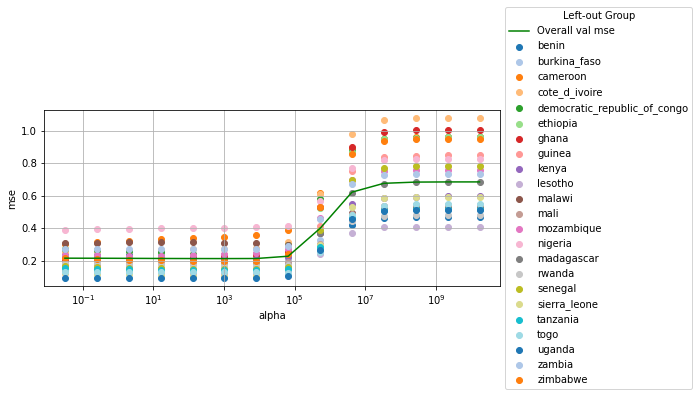

best val mse: 0.214, best alpha: 1024.0, test mse: 0.340
Group: benin


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.20851e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.14759e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.13729e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.55807e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.05298e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.45798e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.6841e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.53904e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.54026e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.216, best alpha: 128.0, test mse: 0.222
Group: burkina_faso


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.1277e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30499e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.14233e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10018e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.06876e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.04881e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08647e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02966e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.0746e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05584e-08): result

best val mse: 0.233, best alpha: 1024.0, test mse: 0.278
Group: cameroon


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.27856e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.60603e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30845e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.23636e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.44664e-08): resul

best val mse: 0.207, best alpha: 0.25, test mse: 0.168
Group: cote_d_ivoire


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.57381e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.56823e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.51964e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61321e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.50314e-08): resul

best val mse: 0.221, best alpha: 1024.0, test mse: 0.333
Group: democratic_republic_of_congo


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.56134e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.61602e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.54313e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.6182e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.48816e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.76049e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.92924e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.6216e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.87968e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.79352e-08): result

best val mse: 0.275, best alpha: 1024.0, test mse: 0.291
Group: ethiopia


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.7398e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.61971e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.64848e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.61137e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.51869e-08): result

best val mse: 0.201, best alpha: 0.25, test mse: 0.302
Group: ghana


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.66685e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72639e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.70863e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.57083e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.66406e-08): resul

best val mse: 0.204, best alpha: 0.25, test mse: 0.239
Group: guinea


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.35707e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.56857e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.97804e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.62234e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.65541e-08): resul

best val mse: 0.206, best alpha: 2.0, test mse: 0.198
Group: kenya


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.6842e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.68699e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.63342e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72796e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.62381e-08): result

best val mse: 0.216, best alpha: 1024.0, test mse: 0.303
Group: lesotho


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.11265e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.04678e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10031e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10187e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.06332e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.04642e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08394e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02616e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.53148e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.30538e-09): resul

best val mse: 0.233, best alpha: 1024.0, test mse: 0.301
Group: malawi


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.06758e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.25853e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.11514e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.15456e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.10056e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.69262e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.44538e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.68506e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.52926e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.53324e-08): resul

best val mse: 0.210, best alpha: 128.0, test mse: 0.312
Group: mali


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.22043e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.74908e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.26266e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.33314e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.05208e-09): resul

best val mse: 0.217, best alpha: 1024.0, test mse: 0.195
Group: mozambique


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.53995e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.79197e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.42559e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.52697e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.38981e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.93399e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.11347e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.78571e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.06093e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.96866e-08): resul

best val mse: 0.279, best alpha: 1024.0, test mse: 0.200
Group: nigeria


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.98146e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.18112e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.84221e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.97623e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.80115e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.34746e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.56262e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.18274e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.49713e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.39526e-08): resul

best val mse: 0.257, best alpha: 2.0, test mse: 0.428
Group: madagascar


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13986e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.22787e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10921e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.32673e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.20588e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.03632e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.32375e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.88765e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.63116e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.45726e-09): resul

best val mse: 0.235, best alpha: 1024.0, test mse: 0.233
Group: rwanda


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.46651e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.47631e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.3513e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.45694e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.31394e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.86674e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.04267e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.72553e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.99196e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.90459e-08): resul

best val mse: 0.265, best alpha: 1024.0, test mse: 0.493
Group: senegal


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.74458e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72957e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.80095e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.02232e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.3515e-08): result

best val mse: 0.193, best alpha: 0.03125, test mse: 0.395
Group: sierra_leone


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61497e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.57313e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.65605e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.55648e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.55003e-08): resul

best val mse: 0.224, best alpha: 1024.0, test mse: 0.185
Group: tanzania


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.16018e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.17172e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42107e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.18588e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10954e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.15247e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.11022e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08785e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13687e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.11747e-08): resul

best val mse: 0.238, best alpha: 1024.0, test mse: 0.202
Group: togo


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.50106e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.4811e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.53588e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30124e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.91933e-08): result

best val mse: 0.207, best alpha: 0.25, test mse: 0.088
Group: uganda


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.69607e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.69372e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.64524e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73607e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.63621e-08): resul

best val mse: 0.229, best alpha: 1024.0, test mse: 0.141
Group: zambia


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.19e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.06986e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.08125e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.5776e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.08737e-09): result ma

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.66975e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.42906e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.66066e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.51303e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.214, best alpha: 1024.0, test mse: 0.270
Group: zimbabwe


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.16669e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30908e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10976e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10508e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10193e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.21379e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.02144e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.09939e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.85894e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.61933e-09): resul

best val mse: 0.227, best alpha: 1024.0, test mse: 0.464
saving test preds to: /home/abenabbes/final_ex/dhs/resnet_ms/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhs/resnet_ms/ridge_weights.npz


In [12]:
model_name = 'resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR,'dhs', 'resnet_ms')
ridgecv_ooc_wrapper(model_name, savedir)

/home/abenabbes/final_ex/dhs/DHS_OOC_A_rgb_same_b64_fc001_conv001_lr01/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
cameroon
ethiopia
ghana
guinea
senegal
togo
/home/abenabbes/final_ex/dhs/DHS_OOC_B_rgb_same_b64_fc001_conv001_lr0001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
burkina_faso
lesotho
madagascar
tanzania
zimbabwe
/home/abenabbes/final_ex/dhs/DHS_OOC_C_rgb_same_b64_fc001_conv001_lr0001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
angola
benin
mali
malawi
zambia
/home/abenabbes/final_ex/dhs/DHS_OOC_D_rgb

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.1406e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.12474e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.19683e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.09228e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.05846e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.36033e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.46584e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.27497e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.43276e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.35772e-08): resul

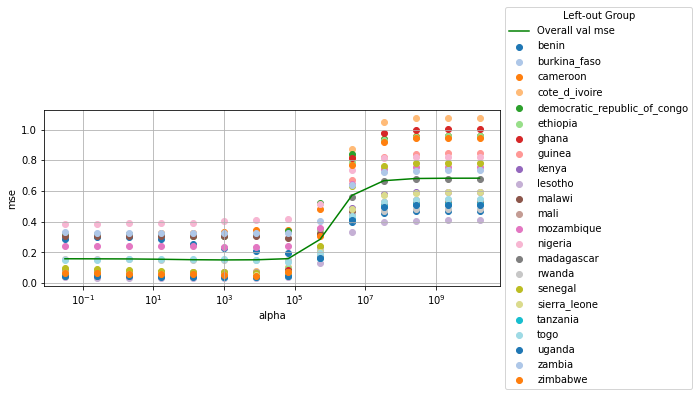

best val mse: 0.152, best alpha: 1024.0, test mse: 0.434
Group: benin


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.1406e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.12753e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.80567e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.70511e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.68982e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.3657e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.47122e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.28145e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.44043e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.36385e-08): result

best val mse: 0.154, best alpha: 128.0, test mse: 0.256
Group: burkina_faso


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.13621e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.12986e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.13868e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.09722e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.06428e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72097e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.85809e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.76173e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.03431e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.96449e-08): resul

best val mse: 0.231, best alpha: 2.0, test mse: 0.227
Group: cameroon


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.67546e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.67801e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.63139e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.62104e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.60011e-08): resul

best val mse: 0.260, best alpha: 128.0, test mse: 0.253
Group: cote_d_ivoire


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73502e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.5089e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.46881e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.52461e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45634e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.69216e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.24919e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.09411e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7741e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72633e-08): result

best val mse: 0.214, best alpha: 2.0, test mse: 0.321
Group: democratic_republic_of_congo


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.67456e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.75838e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.6068e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.67207e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.611e-09): result m

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.22464e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.43104e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.17603e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.35664e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.28382e-08): resul

best val mse: 0.306, best alpha: 0.03125, test mse: 0.303
Group: ethiopia


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.69909e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.65375e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73002e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.63933e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.62303e-08): resul

best val mse: 0.257, best alpha: 128.0, test mse: 0.321
Group: ghana


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70761e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70973e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.66249e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74329e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.65031e-08): resul

best val mse: 0.259, best alpha: 128.0, test mse: 0.282
Group: guinea


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.60069e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.60413e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.56291e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.6355e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.55068e-08): result

best val mse: 0.261, best alpha: 128.0, test mse: 0.217
Group: kenya


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.89048e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.62339e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.60749e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.66941e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.58341e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.86913e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.34104e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.79947e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.96047e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.90785e-08): resul

best val mse: 0.203, best alpha: 0.25, test mse: 0.367
Group: lesotho


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.12491e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.0875e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.13965e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.0917e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.07909e-09): result 

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.85418e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.75642e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.03127e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.78995e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.77319e-08): resul

best val mse: 0.230, best alpha: 2.0, test mse: 0.244
Group: malawi


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.82086e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.22475e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.21157e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.16705e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.78617e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.42758e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.32685e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.33687e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.50792e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.42423e-08): resul

best val mse: 0.148, best alpha: 1024.0, test mse: 0.307
Group: mali


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.76546e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.7693e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.19736e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.26736e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.73951e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.41376e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.52153e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.32717e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.48957e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.41392e-08): resul

best val mse: 0.161, best alpha: 1024.0, test mse: 0.073
Group: mozambique


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.83427e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.93178e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.78713e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.84127e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.78988e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.37415e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.6052e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.32465e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.516e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.4785e-08): result ma

best val mse: 0.308, best alpha: 0.03125, test mse: 0.244
Group: nigeria


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.26523e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.0799e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.16383e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.05253e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.03753e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.93795e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.60938e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.84638e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.78736e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.65656e-08): resul

best val mse: 0.285, best alpha: 0.03125, test mse: 0.478
Group: madagascar


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.16874e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.13113e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.17807e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.11898e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.11915e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.88859e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.78819e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.84587e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.73987e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70673e-08): resul

best val mse: 0.228, best alpha: 2.0, test mse: 0.267
Group: rwanda


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.80595e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.8381e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.69729e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.77905e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.71085e-09): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.32052e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.53063e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.24251e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.44991e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.39806e-08): resul

best val mse: 0.306, best alpha: 0.03125, test mse: 0.280
Group: senegal


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.69162e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.64599e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72374e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.63427e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61513e-08): resul

best val mse: 0.251, best alpha: 128.0, test mse: 0.401
Group: sierra_leone


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.55504e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.56058e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.78432e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.59929e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.52763e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.81591e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26696e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.14882e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.8489e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.79562e-08): result

best val mse: 0.218, best alpha: 2.0, test mse: 0.172
Group: tanzania


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.24998e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.24478e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.18916e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25071e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.19069e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.20196e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.91902e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.84744e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.96351e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.8921e-08): result

best val mse: 0.232, best alpha: 2.0, test mse: 0.221
Group: togo


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.58859e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.59303e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.54971e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.6205e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.53716e-08): result

best val mse: 0.262, best alpha: 128.0, test mse: 0.107
Group: uganda


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.88767e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.63225e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61465e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.65512e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.582e-09): result 

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.26961e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.8489e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.93722e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.77607e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.88336e-08): result

best val mse: 0.221, best alpha: 16.0, test mse: 0.153
Group: zambia


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.20888e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.20952e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.18981e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.26571e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.15579e-09): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.38801e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.40807e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.51607e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.32058e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.48464e-08): resul

best val mse: 0.150, best alpha: 1024.0, test mse: 0.327
Group: zimbabwe


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.14968e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.14505e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.10713e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.16741e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.104e-09): result 

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.90511e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74778e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.86747e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.77369e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.05258e-08): resul

best val mse: 0.220, best alpha: 2.0, test mse: 0.520
saving test preds to: /home/abenabbes/final_ex/dhs/resnet_rgb/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhs/resnet_rgb/ridge_weights.npz


In [17]:
model_name = 'resnet_rgb'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs', 'resnet_rgb')
ridgecv_ooc_wrapper(model_name, savedir)

/home/abenabbes/final_ex/dhs/DHS_OOC_A_nl_random_b64_fc1.0_conv1.0_lr0001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
cameroon
ethiopia
ghana
guinea
senegal
togo
/home/abenabbes/final_ex/dhs/DHS_OOC_B_nl_random_b64_fc1.0_conv1.0_lr0001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
burkina_faso
lesotho
madagascar
tanzania
zimbabwe
/home/abenabbes/final_ex/dhs/DHS_OOC_C_nl_random_b64_fc1.0_conv1.0_lr0001/features.npz
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
angola
benin
mali
malawi
zambia
/home/abenabbes/final_ex/dhs/DHS_OOC_

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.88962e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.07199e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.0318e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.75094e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.91844e-09): result

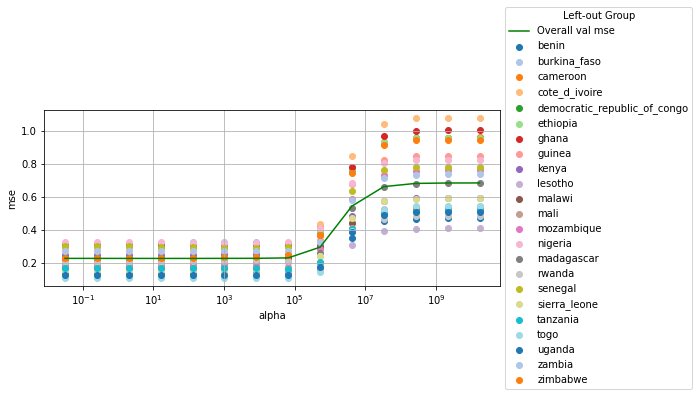

best val mse: 0.228, best alpha: 128.0, test mse: 0.489
Group: benin


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.88962e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.59882e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.18293e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.94739e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.17674e-09): resul

best val mse: 0.238, best alpha: 128.0, test mse: 0.146
Group: burkina_faso


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.2189e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.11199e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.31435e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.51135e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07129e-08): result

best val mse: 0.234, best alpha: 1024.0, test mse: 0.327
Group: cameroon


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05794e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.36122e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.40549e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.99538e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.10494e-09): resul

best val mse: 0.230, best alpha: 1024.0, test mse: 0.313
Group: cote_d_ivoire


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.75841e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.80984e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.45909e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.19776e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.12366e-09): resul

best val mse: 0.236, best alpha: 8192.0, test mse: 0.323
Group: democratic_republic_of_congo


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.97401e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.65026e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.21397e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.47104e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.8441e-10): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00711e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.8279e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.04759e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.81209e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.93112e-08): result

best val mse: 0.249, best alpha: 0.25, test mse: 0.290
Group: ethiopia


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.80453e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.0823e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.14187e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.02348e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.35491e-09): result

best val mse: 0.233, best alpha: 1024.0, test mse: 0.225
Group: ghana


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.45596e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.34667e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.48896e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.76221e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.81503e-09): resul

best val mse: 0.233, best alpha: 1024.0, test mse: 0.221
Group: guinea


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.66505e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.01172e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.31033e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.8e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.41083e-09): result ma

best val mse: 0.234, best alpha: 1024.0, test mse: 0.199
Group: kenya


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07994e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.89241e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.52913e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.45269e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.48757e-10): resul

best val mse: 0.236, best alpha: 8192.0, test mse: 0.255
Group: lesotho


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.40982e-11): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.03268e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.23421e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.93304e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.31896e-09): resul

best val mse: 0.239, best alpha: 1024.0, test mse: 0.158
Group: malawi


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.64652e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.31973e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.20395e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.76962e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.22934e-09): resul

best val mse: 0.229, best alpha: 128.0, test mse: 0.309
Group: mali


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.3534e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.95748e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.11692e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.35433e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.80414e-09): result

best val mse: 0.236, best alpha: 128.0, test mse: 0.185
Group: mozambique


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.11306e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.17888e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.78831e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71797e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.24802e-10): resul

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.29147e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.22888e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.3579e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.91075e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.31376e-08): result

best val mse: 0.250, best alpha: 2.0, test mse: 0.255
Group: nigeria


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.16138e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.28732e-11): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.51799e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.93059e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.9179e-10): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.12148e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.23784e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.30231e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.55573e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.14821e-08): resul

best val mse: 0.238, best alpha: 16.0, test mse: 0.350
Group: madagascar


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.39753e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.12021e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.67135e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.32018e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.14421e-09): resul

best val mse: 0.240, best alpha: 1024.0, test mse: 0.159
Group: rwanda


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.36088e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00767e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.35619e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.25269e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.2881e-10): result

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.03659e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.8539e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.00218e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07504e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.9364e-08): result 

best val mse: 0.252, best alpha: 2.0, test mse: 0.204
Group: senegal


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.47159e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.88024e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.64404e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.06691e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.09499e-09): resul

best val mse: 0.226, best alpha: 1024.0, test mse: 0.330
Group: sierra_leone


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.16595e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.28592e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.32088e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.52502e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.0564e-09): result

best val mse: 0.239, best alpha: 8192.0, test mse: 0.183
Group: tanzania


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.83499e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.49475e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.44365e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.73605e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.21927e-09): resul

best val mse: 0.242, best alpha: 1024.0, test mse: 0.169
Group: togo


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.94865e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.09255e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.45062e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.19866e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.37712e-09): resul

best val mse: 0.235, best alpha: 1024.0, test mse: 0.102
Group: uganda


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.16169e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40024e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.82571e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.55577e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.65863e-09): resul

best val mse: 0.245, best alpha: 8192.0, test mse: 0.127
Group: zambia


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.30513e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.34895e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.90261e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13051e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.66643e-09): resul

best val mse: 0.233, best alpha: 128.0, test mse: 0.272
Group: zimbabwe


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.85742e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.36248e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.24358e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.53943e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.38261e-09): resul

best val mse: 0.237, best alpha: 1024.0, test mse: 0.247
saving test preds to: /home/abenabbes/final_ex/dhs/resnet_nl/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhs/resnet_nl/ridge_weights.npz


In [18]:
model_name = 'resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs', 'resnet_nl')
ridgecv_ooc_wrapper(model_name, savedir)




### Concatenated RGB/MS + NL features

In [19]:
def ridgecv_ooc_concat_wrapper(model_names: Iterable[str], savedir: str) -> None:
    '''
    Args
    - model_names: list of str, correspond to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        print (f)
        concat_features = []  # list of np.array, each shape [N, D_i]
        for model_name in model_names:
            print(model_name)
            model_dir = MODEL_DIRS[f'{model_name}_{f}']
            print(model_dir)
            npz_path = os.path.join(OUTPUTS_ROOT_DIR,'dhs', model_dir, 'features.npz')
            npz = load_npz(npz_path, check={'labels': labels})
            concat_features.append(npz['features'])
        concat_features = np.concatenate(concat_features, axis=1)  # shape [N, D_1 + ... + D_m]
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = concat_features

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=country_labels,
        group_names=countries,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        save_dict=dict(locs=locs),
        verbose=True)
    
    
    
    
    
    

Each of the following 2 cells make take ~3-4 hours each to run.

A
resnet_ms
DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
resnet_nl
DHS_OOC_A_nl_random_b64_fc1.0_conv1.0_lr0001
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
B
resnet_ms
DHS_OOC_B_ms_samescaled_b64_fc001_conv001_lr0001
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
resnet_nl
DHS_OOC_B_nl_random_b64_fc1.0_conv1.0_lr0001
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
C


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.54769e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.75263e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.0638e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.98421e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.41456e-09): result

Alpha: 17179869184.0 (14/14)


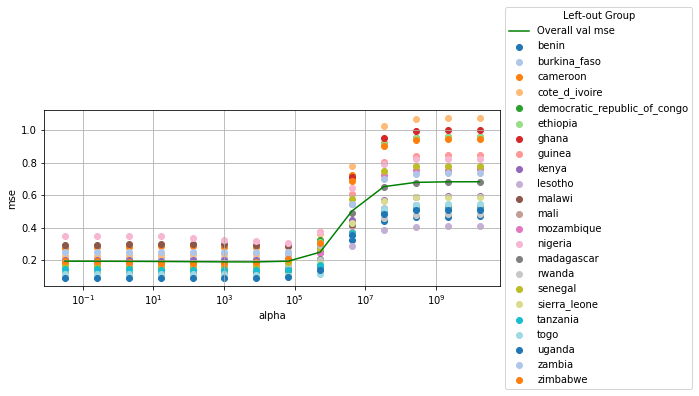

best val mse: 0.191, best alpha: 8192.0, test mse: 0.344
Group: benin
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.54769e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.89706e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.0579e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.23204e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.76321e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.195, best alpha: 8192.0, test mse: 0.171
Group: burkina_faso
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.87451e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43529e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.82519e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.73956e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.6401e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.209, best alpha: 1024.0, test mse: 0.294
Group: cameroon
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.54019e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.62217e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.17535e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.7125e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.32919e-09): result

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.10268e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.192, best alpha: 0.25, test mse: 0.178
Group: cote_d_ivoire
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.75976e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.82849e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.59668e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.4229e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.7899e-09): result 

Alpha: 17179869184.0 (14/14)
best val mse: 0.203, best alpha: 2.0, test mse: 0.293
Group: democratic_republic_of_congo
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.70105e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.26032e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.93131e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.23563e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.80139e-10): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.9076e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.93411e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.85853e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.97012e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.72513e-09): result

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.86568e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.67889e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.75348e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.58924e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.86751e-08): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.232, best alpha: 16.0, test mse: 0.215
Group: ethiopia
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.06212e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.51387e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.04873e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.92865e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.13279e-09): resul

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.88367e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.189, best alpha: 0.25, test mse: 0.241
Group: ghana
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.56802e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.383e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.6179e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.22381e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.09634e-09): result m

Alpha: 17179869184.0 (14/14)
best val mse: 0.191, best alpha: 0.03125, test mse: 0.218
Group: guinea
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.12189e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.28489e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.74372e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.16641e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.57897e-09): resul

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.18426e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.192, best alpha: 0.25, test mse: 0.163
Group: kenya
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.1265e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.70149e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.73719e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.28709e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.23044e-10): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.200, best alpha: 2.0, test mse: 0.265
Group: lesotho
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.62201e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.48104e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.43178e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.00319e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72875e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.212, best alpha: 1024.0, test mse: 0.197
Group: malawi
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.64096e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.83607e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.73589e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.46522e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.22464e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.187, best alpha: 8192.0, test mse: 0.294
Group: mali
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.70118e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.8574e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.39676e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.52733e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.83995e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.196, best alpha: 8192.0, test mse: 0.151
Group: mozambique
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.8689e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.8215e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.76688e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.73742e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.00247e-10): result 

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.28388e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.28219e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.20812e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.3279e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.0648e-09): result 

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.08284e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.70629e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.70741e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.75114e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.73133e-08): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.233, best alpha: 16.0, test mse: 0.202
Group: nigeria
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.22403e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02706e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.86389e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.51148e-11): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.47612e-10): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.09981e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.11055e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.01897e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.17611e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.86189e-09): resul

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.06118e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.24684e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.9334e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.08192e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.91398e-08): result

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.70567e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.219, best alpha: 0.25, test mse: 0.342
Group: madagascar
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.21588e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.93879e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.41742e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.04708e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.13829e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.213, best alpha: 1024.0, test mse: 0.172
Group: rwanda
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.83658e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.84986e-11): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.14002e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.79491e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.12271e-10): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.11627e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.11836e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.06198e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.16959e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.92595e-09): resul

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.89803e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.69819e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.77956e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.77585e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.90361e-08): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.230, best alpha: 16.0, test mse: 0.270
Group: senegal
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.77534e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.82109e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.90366e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.43165e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.15532e-09): resul

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.95915e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.182, best alpha: 0.25, test mse: 0.334
Group: sierra_leone
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.33558e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.49478e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.81536e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.65437e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.41117e-10): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.205, best alpha: 2.0, test mse: 0.185
Group: tanzania
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.65777e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25245e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.21214e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33712e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.06024e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.215, best alpha: 1024.0, test mse: 0.173
Group: togo
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.72881e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.5527e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.00621e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.91203e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.49783e-09): result

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.80606e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.193, best alpha: 0.25, test mse: 0.089
Group: uganda
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.67636e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.3923e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.77656e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.44566e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.72756e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.211, best alpha: 2.0, test mse: 0.121
Group: zambia
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.80427e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.46856e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.90566e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.49756e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.24575e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.192, best alpha: 8192.0, test mse: 0.250
Group: zimbabwe
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.20705e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.79874e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.8612e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40985e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.08471e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.207, best alpha: 1024.0, test mse: 0.338
saving test preds to: /home/abenabbes/final_ex/dhs/resnet_msnl_concat/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhs/resnet_msnl_concat/ridge_weights.npz


In [20]:
model_names = ['resnet_ms', 'resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs', 'resnet_msnl_concat')
ridgecv_ooc_concat_wrapper(model_names, savedir)

A
resnet_rgb
DHS_OOC_A_rgb_same_b64_fc001_conv001_lr01
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
resnet_nl
DHS_OOC_A_nl_random_b64_fc1.0_conv1.0_lr0001
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
B
resnet_rgb
DHS_OOC_B_rgb_same_b64_fc001_conv001_lr0001
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
resnet_nl
DHS_OOC_B_nl_random_b64_fc1.0_conv1.0_lr0001
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
C
resnet_r

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.62811e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.25283e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.77278e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.10035e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.06589e-09): resul

Alpha: 17179869184.0 (14/14)


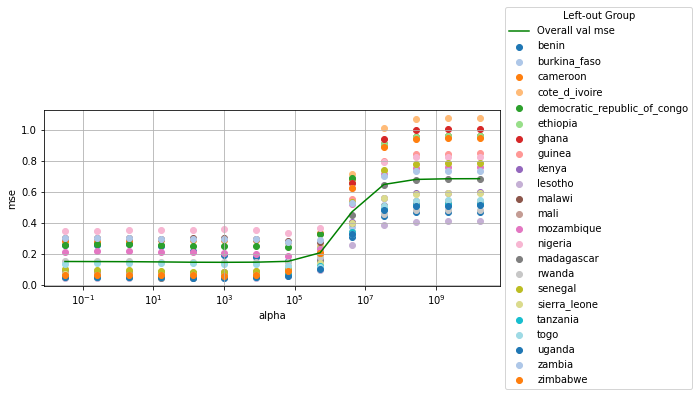

best val mse: 0.144, best alpha: 1024.0, test mse: 0.390
Group: benin
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.62811e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.90383e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.62289e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.24712e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.50958e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.146, best alpha: 128.0, test mse: 0.216
Group: burkina_faso
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.7148e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.97064e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.36531e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.03209e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.09275e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.203, best alpha: 128.0, test mse: 0.251
Group: cameroon
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.5476e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.50088e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.59199e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.41175e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.69715e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.216, best alpha: 16.0, test mse: 0.237
Group: cote_d_ivoire
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.124e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.70143e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02365e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.23027e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.84928e-09): result 

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.76591e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.70484e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.80652e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.86645e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.87057e-08): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.194, best alpha: 2.0, test mse: 0.294
Group: democratic_republic_of_congo
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.00994e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.03178e-11): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.88398e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.52953e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.07616e-10): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42408e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42786e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.41883e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.43569e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.39827e-08): resul

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.29042e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.12584e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.1711e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.06151e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.19548e-08): result

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.3809e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.233, best alpha: 0.25, test mse: 0.234
Group: ethiopia
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.51954e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.41656e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.12589e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.82764e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.03007e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.216, best alpha: 16.0, test mse: 0.225
Group: ghana
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.32354e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.52832e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.31048e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.9376e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.25087e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.217, best alpha: 16.0, test mse: 0.212
Group: guinea
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.19291e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.0709e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.02967e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.15703e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.84605e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.217, best alpha: 16.0, test mse: 0.175
Group: kenya
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.43008e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.65922e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.16838e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.13392e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.56716e-10): resul

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.95021e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.9073e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.16325e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.89073e-10): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.186, best alpha: 0.25, test mse: 0.306
Group: lesotho
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.87461e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.91623e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.90002e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.89615e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.54782e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.205, best alpha: 128.0, test mse: 0.170
Group: malawi
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.46001e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.54553e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.0308e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.20615e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.27615e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.139, best alpha: 1024.0, test mse: 0.299
Group: mali
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.95583e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.38218e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.80065e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.45311e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.33514e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.152, best alpha: 1024.0, test mse: 0.079
Group: mozambique
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.38634e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.9759e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.0756e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.74387e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.69855e-10): result 

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.48555e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.49239e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.47665e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.88332e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.45479e-08): resul

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.42387e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.13539e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.17793e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.20447e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.21475e-08): resul

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.4281e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.234, best alpha: 0.25, test mse: 0.200
Group: nigeria
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.49506e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.54155e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.18506e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.19434e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.53834e-11): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.62285e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.62039e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.49199e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.81501e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.57873e-08): resul

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.39484e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.51957e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.3133e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.4615e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.31065e-08): result 

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.55515e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.222, best alpha: 0.25, test mse: 0.327
Group: madagascar
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.01915e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.68186e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.03837e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.39237e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.39771e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.205, best alpha: 128.0, test mse: 0.179
Group: rwanda
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.27276e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.04512e-11): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.28437e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.92757e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.846e-10): result 

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.45599e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.59667e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.45419e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.4658e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42881e-08): result

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.3254e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.12009e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.24772e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.21965e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.22954e-08): result

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.08886e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.233, best alpha: 0.25, test mse: 0.218
Group: senegal
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.92594e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.20217e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.52987e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.10296e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.1396e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.212, best alpha: 16.0, test mse: 0.286
Group: sierra_leone
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.7503e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42504e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.97818e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.72968e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.56656e-10): result

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.86867e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.7129e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.74672e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.84553e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.73839e-08): result

Alpha: 17179869184.0 (14/14)


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.62841e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.197, best alpha: 2.0, test mse: 0.156
Group: tanzania
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.43617e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7081e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.94809e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.282e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.92656e-09): result m

Alpha: 17179869184.0 (14/14)
best val mse: 0.207, best alpha: 128.0, test mse: 0.177
Group: togo
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.22859e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.70839e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.62879e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.32348e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.67961e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.218, best alpha: 16.0, test mse: 0.101
Group: uganda
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.58355e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.59433e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.46361e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.34768e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.15644e-09): resul

Alpha: 2.0 (3/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.71856e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.75531e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.200, best alpha: 2.0, test mse: 0.129
Group: zambia
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.12318e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.52171e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.34413e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.15002e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42945e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.143, best alpha: 1024.0, test mse: 0.294
Group: zimbabwe
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.57354e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.98972e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.8157e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.62885e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.44134e-09): result

Alpha: 17179869184.0 (14/14)
best val mse: 0.198, best alpha: 16.0, test mse: 0.363
saving test preds to: /home/abenabbes/final_ex/dhs/resnet_rgbnl_concat/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhs/resnet_rgbnl_concat/ridge_weights.npz


In [21]:
model_names = ['resnet_rgb', 'resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs', 'resnet_rgbnl_concat')
ridgecv_ooc_concat_wrapper(model_names, savedir)

## Incountry

In [22]:
def ridgecv_incountry_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        print(model_fold_name)
        print(labels)
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhsincountry', model_dir, 'features.npz')
        print(labels)
        npz = load_npz(npz_path, check={'labels': labels})
        features_dict[f] = npz['features']

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

incountry_resnet_rgb_A
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_rgb_B
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_rgb_C
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.47954e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.44682e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.79662e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.92881e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)


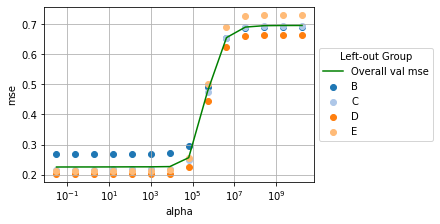

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.03169e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.15284e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.225, best alpha: 0.03125, test mse: 0.260
Group: B
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.64503e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.40393e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.38662e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.90927e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.62638e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.224, best alpha: 0.03125, test mse: 0.277
Group: C
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74362e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.62415e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.21601e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.53482e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.77297e-09): resul

Alpha: 17179869184.0 (14/14)
best val mse: 0.222, best alpha: 0.03125, test mse: 0.260
Group: D
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33833e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.04286e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.93548e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.30715e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.35314e-09): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.65727e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.42619e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.340, best alpha: 0.03125, test mse: 0.307
Group: E
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.69685e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.50514e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.41348e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.46015e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.40418e-09): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.7967e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.80182e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.72195e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.74016e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.224, best alpha: 0.03125, test mse: 0.245
saving test preds to: /home/abenabbes/final_ex/dhsincountry/resnet_rgb/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhsincountry/resnet_rgb/ridge_weights.npz


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.36671e-09): result may not be accurate.
  overwrite_a=True).T


In [23]:
model_name = 'incountry_resnet_rgb'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhsincountry', 'resnet_rgb')
ridgecv_incountry_wrapper(model_name, savedir)

incountry_resnet_ms_A
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_ms_B
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_ms_C
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
l

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.81991e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.01937e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.64177e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.16817e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)


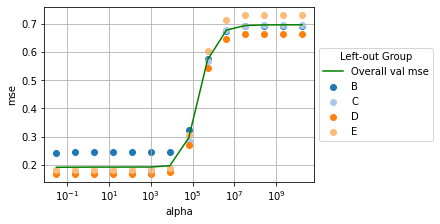

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.8457e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.58273e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.39221e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.191, best alpha: 0.03125, test mse: 0.233
Group: B
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61745e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.5861e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.227, best alpha: 0.03125, test mse: 0.252
Group: C
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.91168e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.10185e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.53579e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.44027e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.37613e-09): resul

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.70931e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.76789e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.66989e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.213, best alpha: 0.03125, test mse: 0.248
Group: D
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.80113e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.212, best alpha: 0.03125, test mse: 0.215
Group: E
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.67712e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.72917e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.7068e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.74493e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.25048e-08): result

Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.48116e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.23297e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.192, best alpha: 2.0, test mse: 0.228
saving test preds to: /home/abenabbes/final_ex/dhsincountry/resnet_ms/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhsincountry/resnet_ms/ridge_weights.npz


In [25]:
model_name = 'incountry_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhsincountry', 'resnet_ms')
ridgecv_incountry_wrapper(model_name, savedir)

### Concatenated MS + NL Features

In [26]:
def ridgecv_incountry_concat_wrapper(model_names: Iterable[str], savedir: str) -> None:
    '''
    Args
    - model_names: list of str, correspond to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for i, f in enumerate(FOLDS):
        concat_features = []  # list of np.array, each shape [N, D_i]
        for model_name in model_names:
            print(model_name)
            model_dir = MODEL_DIRS[f'{model_name}_{f}']
            npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'dhsincountry', model_dir, 'features.npz')
            npz = load_npz(npz_path, check={'labels': labels})
            concat_features.append(npz['features'])
        concat_features = np.concatenate(concat_features, axis=1)  # shape [N, D_1 + ... + D_m]
        features_dict[f] = concat_features

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

incountry_resnet_rgb
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_nl
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_rgb
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_nl
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_rgb
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtyp

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.71891e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.58182e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.7368e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.65191e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)


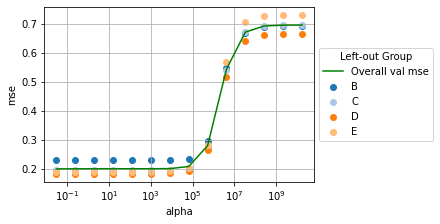

best val mse: 0.200, best alpha: 0.03125, test mse: 0.224
Group: B
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.1426e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.23066e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.1451e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.26133e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.201, best alpha: 0.03125, test mse: 0.236
Group: C
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.43318e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.01817e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.17886e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.99019e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.198, best alpha: 0.03125, test mse: 0.221
Group: D
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.8118e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.74315e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.50719e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.25831e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.228, best alpha: 0.03125, test mse: 0.213
Group: E
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.79432e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.17149e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.7002e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.14957e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.75699e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.75238e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.74494e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.6902e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.205, best alpha: 0.03125, test mse: 0.205
saving test preds to: /home/abenabbes/final_ex/dhsincountry/resnet_rgbnl_concat/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhsincountry/resnet_rgbnl_concat/ridge_weights.npz


/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.82483e-10): result may not be accurate.
  overwrite_a=True).T


In [27]:
model_names = ['incountry_resnet_rgb', 'incountry_resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhsincountry', 'resnet_rgbnl_concat')
ridgecv_incountry_concat_wrapper(model_names, savedir)



incountry_resnet_ms
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_nl
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_ms
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_nl
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=float32, shape=(36182, 2)
years: dtype=int32, shape=(36182,)
incountry_resnet_ms
features: dtype=float32, shape=(36182, 512)
preds: dtype=float32, shape=(36182,)
labels: dtype=float32, shape=(36182,)
locs: dtype=f

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.44618e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.80823e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.18885e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.34062e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)


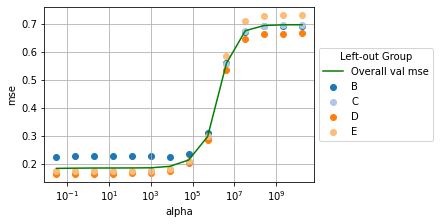

best val mse: 0.183, best alpha: 0.03125, test mse: 0.217
Group: B
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.44132e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.80021e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30794e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.46423e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.209, best alpha: 0.03125, test mse: 0.225
Group: C
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.57309e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.86025e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.64414e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.52172e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.196, best alpha: 0.03125, test mse: 0.216
Group: D
Alpha: 0.25 (2/14)14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.8886e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.20177e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.35586e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.49345e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.196, best alpha: 0.03125, test mse: 0.192
Group: E
Alpha: 0.03125 (1/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.1801e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.68403e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.6048e-10): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.36558e-10): result may not be accurate.
  overwrite_a=True).T


Alpha: 0.25 (2/14)

/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.99403e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91229e-09): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00915e-08): result may not be accurate.
  overwrite_a=True).T
/home/abenabbes/anaconda3/envs/py24/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91447e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)
best val mse: 0.184, best alpha: 2.0, test mse: 0.205
saving test preds to: /home/abenabbes/final_ex/dhsincountry/resnet_msnl_concat/test_preds.npz
saving ridge_weights to: /home/abenabbes/final_ex/dhsincountry/resnet_msnl_concat/ridge_weights.npz


In [28]:
model_names = ['incountry_resnet_ms', 'incountry_resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhsincountry', 'resnet_msnl_concat')
ridgecv_incountry_concat_wrapper(model_names, savedir)

### Transfer

In [ ]:
DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001

In [ ]:
def ridgecv_incountry_transfer_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    model_dir = MODEL_DIRS[model_name]
    npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', model_dir, 'features.npz')
    features = load_npz(npz_path, check={'labels': labels})['features']
    ridge_cv(
        features=features,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=False)

In [ ]:
model_name = 'transfer_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)

In [ ]:
model_name = 'transfer_resnet_rgb'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)